In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date, timedelta, timezone
import pandas as pd
import numpy as np
import random
import warnings
warnings.simplefilter('ignore')

from backtesting import Backtest, Strategy
import backtrader as bat
import vectorbt as vbt

Loading BokehJS ...

In [2]:
def make_bar(Open=None, High=None, Low=None, Close=None, Volume=None, dt=None):
    return {"Open": Open, "High": High, "Low": Low, "Close": Close, "Volume": Volume, "dt": dt}

def cagr(v0: float, vT: float, start: str, end: str, dayfirst: bool = True) -> float:
    dt0 = datetime.strptime(start, "%d-%m-%Y" if dayfirst else "%m-%d-%Y")
    dt1 = datetime.strptime(end,   "%d-%m-%Y" if dayfirst else "%m-%d-%Y")
    years = (dt1 - dt0).days / 365.25
    if v0 <= 0 or vT <= 0 or years <= 0:
        raise ValueError("Values and time span must be positive.")
    return (vT / v0) ** (1 / years) - 1

def sharpe_from_snapshots(df, equity_col="total_value", periods_per_year=252, rf_annual=0.0):
    equity = df[equity_col].astype(float).to_numpy()

    # simple returns
    rets = equity[1:] / equity[:-1] - 1.0

    # annual risk-free -> per-period
    rf_period = (1.0 + rf_annual) ** (1.0 / periods_per_year) - 1.0
    excess = rets - rf_period

    mu = np.mean(excess)
    sigma = np.std(excess, ddof=1)  # sample std

    if sigma == 0 or np.isnan(sigma):
        return np.nan

    return (mu / sigma) * np.sqrt(periods_per_year)

# Previous

## DataHandler

In [3]:
from pathlib import Path
import sys

# Path to .../TMRW/Backtest (this notebook's folder)
here = Path.cwd()

# Repo root: .../TMRW
repo_root = here.parent

# Add repo root so Python can find IT/Backend.py
sys.path.insert(0, str(repo_root))

from IT.Backend import to_iso_date, shift_date_iso, _to_date, date_distance
# or:
import IT.Backend as backend

In [4]:
class DataHandler:

    def __init__(self, ticker="", start="", end=""):

        self.t = 0
        
        if ticker == "":
            self.ticker = "AAPL"
        else:
            self.ticker = ticker

        if start == "":
            self.start = "2014-06-05"
        else:
            self.start = to_iso_date(start)

        if end == "":
            self.end = "2024-06-06"
        else:
            self.end = to_iso_date(end)

        if date_distance(self.start, self.end) < 60:
            print("The two dates were too close together, the start date has been adjusted")
            self.start = shift_date_iso(self.start, -60)
        
        self.fetch_data()

    def fetch_data(self):
        self.data = yf.download(self.ticker, self.start, self.end)

    def feed(self):
        self.t = self.t + 1
        return(self.data.iloc[self.t-1])

## Strategy

In [36]:
class StrategyCore:
    def __init__(self, strat):
        self.strat = strat

    def on_bar(self, bar) -> dict:
        """
        bar: dict-like with at least 'Open','High','Low','Close','Volume','dt'
        returns: {"side": "buy"/"sell"/"hold", "value": 10.0} or {"qty": ...}
        """
        self.strat._update(bar)
        dec = self.strat.decision()
        if dec == "buy":
            return {"side": "buy", "value": 10.0}
        if dec == "sell":
            return {"side": "sell", "value": 10.0}
        return {"side": "hold", "value": 0.0}


In [6]:
class strategy:

    def __init__(self):
        print("booting up")

        self.Open = []
        self.High = []
        self.Low = []
        self.Close = []
        self.Volume = []
        self.MA6 = []
        self.MA21 = []
        self.data = []
        self.buy = True
        self.t = 0

    def _update(self, data):
        
        self.Open.append(data.Open)
        self.High.append(data.High)
        self.Low.append(data.Low)
        self.Close.append(data.Close)
        self.Volume.append(data.Volume)
        
        if len(self.Open) >= 6:
            self.MA6.append(np.mean(self.Open[-6:]))

        if len(self.Open) >= 21:
            self.MA21.append(np.mean(self.Open[-21:]))

    def decision(self):   
        if len(self.MA21) > 29:
            if self.MA21[len(self.MA21)-1] > self.MA6[len(self.MA6)-1]:
                self.data.append(["buy", len(self.Open)])
                self.buy = False
                return("buy")
    
            elif self.MA21[len(self.MA21)-1] < self.MA6[len(self.MA6)-1]:
                self.data.append(["sell", len(self.Open)])
                self.buy = True
                return("sell")
    

        

## Account/PM/inventory

In [7]:
class account:
    COLS = ["value", "amount", "max amount", "ideal amount", "allocation", "riskiness", "urgency"]

    def __init__(self, symbols=None, value=None, inventory=None):
        self.inventory = pd.DataFrame(columns=self.COLS, dtype="float64")
        self.inventory.loc["Total"] = 0.0
        self.inventory.loc["Rest"]  = 0.0  # cash
        self.price = None

        if symbols is not None and value is not None and inventory is not None:
            self._add_inventory(symbols=symbols, value=value, inventory=inventory)

    # ---------- small helpers ----------
    def _cash(self) -> float:
        return float(self.inventory.at["Rest", "value"])

    def _set_cash(self, cash: float) -> None:
        self.inventory.at["Rest", "value"] = float(cash)

    def _ensure_symbol_row(self, symbol: str) -> None:
        if symbol not in self.inventory.index:
            self.inventory.loc[symbol] = 0.0

    def fetch_price(self, price: float) -> None:
        if price is None or price <= 0:
            raise ValueError("Price must be a positive number.")
        self.price = float(price)

    # ---------- bookkeeping ----------
    def _add_value(self, value: float) -> None:
        if value is None:
            return
        self._set_cash(self._cash() + float(value))
        self._update_account()

    def _add_inventory(self, symbols: str, value: float, inventory: float) -> None:
        if symbols is None:
            raise ValueError("A symbol must be specified.")
        self._ensure_symbol_row(symbols)
        self.inventory.at[symbols, "value"] = float(value)
        self.inventory.at[symbols, "amount"] = float(inventory)
        self._update_account()

    def _update_account(self) -> None:
        # sum only "real" symbols (exclude Total/Rest)
        symbols = [i for i in self.inventory.index if i not in ("Total", "Rest")]
        positions_value = float(self.inventory.loc[symbols, "value"].sum()) if symbols else 0.0
        positions_amount = float(self.inventory.loc[symbols, "amount"].sum()) if symbols else 0.0

        total_value = positions_value + self._cash()

        self.inventory.at["Total", "value"] = total_value
        self.inventory.at["Total", "amount"] = positions_amount
        # keep Rest.amount at 0
        self.inventory.at["Rest", "amount"] = 0.0

    # ---------- trading ----------
    def _buy_shares(self, symbols: str, value: float = None, inventory: float = None) -> None:
        if symbols is None:
            raise ValueError("A symbol must be specified.")
        if self.price is None:
            raise ValueError("Set a price first via fetch_price().")
        if self._cash() <= 0:
            return

        self._ensure_symbol_row(symbols)

        # choose qty to buy
        if value is None and inventory is not None:
            qty = float(inventory)
        elif value is not None and inventory is None:
            qty = float(value) / self.price
        else:
            raise ValueError("Either buy by inventory (qty) OR by value, not both.")

        # clamp to available cash
        max_qty = self._cash() / self.price
        qty = max(0.0, min(qty, max_qty))
        cost = qty * self.price

        # update position (ADD, don't overwrite)
        self.inventory.at[symbols, "amount"] = float(self.inventory.at[symbols, "amount"]) + qty
        self.inventory.at[symbols, "value"]  = float(self.inventory.at[symbols, "amount"]) * self.price

        # update cash ("Rest")
        self._set_cash(self._cash() - cost)

        self._update_account()

    def _sell_shares(self, symbols: str, value: float = None, inventory: float = None) -> None:
        if symbols is None:
            raise ValueError("A symbol must be specified.")
        if self.price is None:
            raise ValueError("Set a price first via fetch_price().")
        if symbols not in self.inventory.index:
            return

        current_qty = float(self.inventory.at[symbols, "amount"])
        if current_qty <= 0:
            return

        # choose qty to sell
        if value is None and inventory is not None:
            qty = float(inventory)
        elif value is not None and inventory is None:
            qty = float(value) / self.price
        else:
            raise ValueError("Either sell by inventory (qty) OR by value, not both.")

        # clamp to what you have
        qty = max(0.0, min(qty, current_qty))
        proceeds = qty * self.price

        # update position
        new_qty = current_qty - qty
        self.inventory.at[symbols, "amount"] = new_qty
        self.inventory.at[symbols, "value"]  = new_qty * self.price

        # update cash ("Rest")
        self._set_cash(self._cash() + proceeds)

        self._update_account()

    def trade_qty(self, symbol: str, side: str, qty: float, fill_price: float, fee_cash: float = 0.0):

        self._ensure_symbol_row(symbol)

        qty = float(qty)
        if qty <= 0:
            return

        cash = self._cash()

        if side == "buy":
            cost = qty * fill_price + fee_cash
            # clamp to affordable
            if cost > cash and fill_price > 0:
                qty = max(0.0, (cash - fee_cash) / fill_price)
                cost = qty * fill_price + fee_cash
            if qty <= 0:
                return

            self.inventory.at[symbol, "amount"] = float(self.inventory.at[symbol, "amount"]) + qty
            self.inventory.at[symbol, "value"]  = float(self.inventory.at[symbol, "amount"]) * fill_price
            self._set_cash(cash - cost)

        elif side == "sell":
            pos_qty = float(self.inventory.at[symbol, "amount"])
            qty = min(qty, pos_qty)
            if qty <= 0:
                return

            proceeds = qty * fill_price - fee_cash
            proceeds = max(0.0, proceeds)

            self.inventory.at[symbol, "amount"] = pos_qty - qty
            self.inventory.at[symbol, "value"]  = float(self.inventory.at[symbol, "amount"]) * fill_price
            self._set_cash(cash + proceeds)

        else:
            raise ValueError("side must be 'buy' or 'sell'")

        self._update_account()

## Backtesting

### self-build

In [8]:
def MC_bridge(
    a: float = 0.0,          # X(0)
    b: float = 0.0,          # X(T)
    sigma: float = 1.0,      # diffusion scale
    T: float = 1.0,
    n_steps: int = 100,
    n_paths: int = 1,
    seed: int | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Brownian bridge X_t with X_0=a and X_T=b:
        X_t = a + (t/T)(b-a) + sigma*(B_t - (t/T)B_T)

    Returns:
      t: shape (n_steps+1,)
      X: shape (n_paths, n_steps+1)
    """
    if T <= 0 or n_steps <= 0 or n_paths <= 0:
        raise ValueError("T, n_steps, n_paths must be positive")
    if sigma < 0:
        raise ValueError("sigma must be >= 0")

    rng = np.random.default_rng(seed)
    dt = T / n_steps

    # Simulate standard Brownian motion B on the grid
    Z = rng.standard_normal((n_paths, n_steps))
    dB = np.sqrt(dt) * Z
    B = np.zeros((n_paths, n_steps + 1), dtype=float)
    B[:, 1:] = np.cumsum(dB, axis=1)

    # Time grid
    t = np.linspace(0.0, T, n_steps + 1)
    tau = (t / T)[None, :]  # shape (1, n_steps+1)

    # Bridge transform
    X = a + tau * (b - a) + sigma * (B - tau * B[:, [-1]])
    return t, X


In [9]:
from dataclasses import dataclass

@dataclass
class ExecutionModel:
    fee_fixed: float = 0.0           # e.g. £1 per trade
    fee_bps: float = 0.0             # e.g. 2 = 2 bps
    slippage_bps: float = 0.0        # e.g. 5 = 5 bps
    adv: float | None = None         # average daily volume in shares (optional)
    impact_bps_at_1pct_adv: float = 0.0  # extra slippage if trade is large

    def fill(self, side: str, ref_price: float, qty: float) -> tuple[float, float]:
        """
        Returns (fill_price, fee_cash).
        side: 'buy' or 'sell'
        qty: shares
        """
        if ref_price <= 0:
            raise ValueError("ref_price must be > 0")
        if qty <= 0:
            return ref_price, 0.0

        # base slippage
        slip = self.slippage_bps / 1e4

        # optional size impact (very simple)
        if self.adv and self.adv > 0 and self.impact_bps_at_1pct_adv > 0:
            frac_adv = qty / self.adv
            # scale linearly relative to 1% ADV
            slip += (self.impact_bps_at_1pct_adv / 1e4) * (frac_adv / 0.01)

        # buy pays worse (higher), sell pays worse (lower)
        if side == "buy":
            fill_price = ref_price * (1.0 + slip)
        elif side == "sell":
            fill_price = ref_price * (1.0 - slip)
        else:
            raise ValueError("side must be 'buy' or 'sell'")

        notional = abs(qty) * fill_price
        fee_cash = self.fee_fixed + (self.fee_bps / 1e4) * notional

        return fill_price, fee_cash


In [78]:
import random
import pandas as pd

class backtest:
    def __init__(self, data_handler, strategy, account, execution: ExecutionModel, symbol: str):
        self.data = data_handler
        self.strat = strategy
        self.acc = account
        self.exec = execution
        self.symbol = symbol

        self.trades = []   # list of dicts
        self.snapshots = []  # per bar equity/cash/pos
        self.bar = []

    def _mark_to_market(self, price: float):
        # mark the position value at current price (doesn't trade)
        if self.symbol in self.acc.inventory.index:
            qty = float(self.acc.inventory.at[self.symbol, "amount"])
            self.acc.inventory.at[self.symbol, "value"] = qty * price
        self.acc._update_account()

    def run(self, n_bridge_points: int = 101, seed: int | None = None):
        if seed is not None:
            random.seed(seed)

        # ensure row exists
        self.acc._ensure_symbol_row(self.symbol)

        for i in range(len(self.data.data)):
            bar = self.data.feed()  # should return something like a row/frame with Open/Close

            open_px = float(bar.Open[0])
            close_px = float(bar.Close[0])

            # mark-to-market at open
            self._mark_to_market(open_px)

            # strategy uses bar info (open/close etc)
            self.strat._update(bar)
            decision = self.strat.decision()   # call once

            # choose an execution reference price (your MC middle price)
            t, X = MC_bridge(open_px, close_px)  # assumes returns X shape [1][N]
            r = random.randint(0, n_bridge_points - 1)
            mid_px = float(X[0][r])
            if mid_px < 0: 
                mid_px = close_px

            # execute
            if decision in ("buy", "sell"):
                # example: trade by value/notional = 10
                notional = 10.0
                qty = notional / mid_px if mid_px > 0 else 0.0

                fill_px, fee = self.exec.fill(decision, ref_price=mid_px, qty=qty)
                self.acc.trade_qty(self.symbol, decision, qty=qty, fill_price=fill_px, fee_cash=fee)

                self.trades.append({
                    "i": i,
                    "side": decision,
                    "qty": qty,
                    "ref_price": mid_px,
                    "fill_price": fill_px,
                    "fee": fee,
                    "cash_after": self.acc._cash(),
                    "pos_after": float(self.acc.inventory.at[self.symbol, "amount"]),
                    "total_value_after": float(self.acc.inventory.at["Total", "value"]),
                })

            # mark-to-market at close (end of bar)
            self._mark_to_market(close_px)

            self.snapshots.append({
                "i": i,
                "open": open_px,
                "mid": mid_px,
                "close": close_px,
                "decision": decision,
                "cash": self.acc._cash(),
                "pos_qty": float(self.acc.inventory.at[self.symbol, "amount"]),
                "total_value": float(self.acc.inventory.at["Total", "value"]),
            })

        return pd.DataFrame(self.snapshots), pd.DataFrame(self.trades)


### Backtesting

In [82]:
from types import SimpleNamespace
import pandas as pd
from backtesting import Backtest, Strategy

def _to_ohlcv_df(datahandler, ticker=None) -> pd.DataFrame:
    """
    Returns a DataFrame with columns: Open, High, Low, Close, Volume
    Handles yfinance outputs that may be single-index or MultiIndex columns.
    """
    df = datahandler.data.copy()

    # If yfinance returned MultiIndex columns (e.g. (PriceField, Ticker))
    if isinstance(df.columns, pd.MultiIndex):
        names = df.columns.names

        # If ticker level exists and we want one ticker
        if "Ticker" in names:
            lvl = names.index("Ticker")
            if ticker is None:
                # If only one ticker present, just drop the level
                if len(df.columns.levels[lvl]) == 1:
                    df.columns = df.columns.droplevel("Ticker")
                else:
                    # pick the handler ticker if not provided
                    ticker = getattr(datahandler, "ticker", None) or df.columns.levels[lvl][0]
                    df = df.xs(ticker, axis=1, level="Ticker")
            else:
                df = df.xs(ticker, axis=1, level="Ticker")

        else:
            # If unnamed MultiIndex, assume level 1 is ticker
            if ticker is None and len(df.columns.levels[1]) == 1:
                df.columns = df.columns.droplevel(1)
            else:
                ticker = ticker or getattr(datahandler, "ticker", None) or df.columns.levels[1][0]
                df = df.xs(ticker, axis=1, level=1)

    # Standardize column names (yfinance sometimes uses Adj Close)
    required = ["Open", "High", "Low", "Close"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}'. Available: {list(df.columns)}")

    if "Volume" not in df.columns:
        df["Volume"] = 0.0

    df = df[["Open", "High", "Low", "Close", "Volume"]].dropna()

    return df


def run_in_backtesting_py(data_handler, strategy_core, cash=10_000, commission=0.0, ticker=None):
    df = _to_ohlcv_df(data_handler, ticker=ticker)

    class BTpyAdapter(Strategy):
        def init(self):
            self.core = strategy_core

        def next(self):
            # IMPORTANT: use backtesting.py's self.data, DO NOT overwrite self.data
            bar_obj = SimpleNamespace(
                Open=float(self.data.Open[-1]),
                High=float(self.data.High[-1]),
                Low=float(self.data.Low[-1]),
                Close=float(self.data.Close[-1]),
                Volume=float(self.data.Volume[-1]) if hasattr(self.data, "Volume") else 0.0,
            )

            action = self.core.on_bar(bar_obj)

            price = bar_obj.Close
            
            qty = action.get("qty")
            if qty is None and "value" in action:
                qty = float(action["value"]) / price if price > 0 else 0.0
            
            qty = int(qty)  # IMPORTANT: backtesting.py needs integer units unless using fraction-of-equity
            
            if action.get("side") == "buy" and qty > 0:
                self.buy(size=qty)
            
            elif action.get("side") == "sell":
                if self.position.is_long:
                    self.position.close()   # closes existing long
                # else: optionally allow shorting via self.sell(size=qty)

    my_bt = Backtest(df, BTpyAdapter, cash=cash, commission=commission)
    return my_bt.run()



### Backtrader

In [51]:
import pandas as pd
import backtrader as bt
from types import SimpleNamespace

def run_in_backtrader(data_handler, strategy_core, cash=10_000,
                      commission_bps=50.0, slippage_bps=50.0, ticker=None):

    # --- convert DataHandler data to single-ticker OHLCV dataframe ---
    df = data_handler.data.copy()

    if isinstance(df.columns, pd.MultiIndex):
        if "Ticker" in df.columns.names:
            if ticker is None:
                # if only one ticker, drop it
                lvl = df.columns.names.index("Ticker")
                if len(df.columns.levels[lvl]) == 1:
                    df.columns = df.columns.droplevel("Ticker")
                else:
                    ticker = getattr(data_handler, "ticker", None) or df.columns.levels[lvl][0]
                    df = df.xs(ticker, axis=1, level="Ticker")
            else:
                df = df.xs(ticker, axis=1, level="Ticker")
        else:
            # unnamed multiindex – assume level 1 is ticker
            if ticker is None and len(df.columns.levels[1]) == 1:
                df.columns = df.columns.droplevel(1)
            else:
                ticker = ticker or getattr(data_handler, "ticker", None) or df.columns.levels[1][0]
                df = df.xs(ticker, axis=1, level=1)

    # Ensure required columns exist
    required = ["Open", "High", "Low", "Close"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing '{c}'. Available: {list(df.columns)}")
    if "Volume" not in df.columns:
        df["Volume"] = 0.0

    df = df[["Open", "High", "Low", "Close", "Volume"]].dropna()

    # Backtrader prefers a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    data = bt.feeds.PandasData(dataname=df)

    class BTAdapter(bt.Strategy):
        def __init__(self):
            self.core = strategy_core

        def next(self):
            bar_obj = SimpleNamespace(
                Open=float(self.data.open[0]),
                High=float(self.data.high[0]),
                Low=float(self.data.low[0]),
                Close=float(self.data.close[0]),
                Volume=float(self.data.volume[0]) if hasattr(self.data, "volume") else 0.0,
            )

            action = self.core.on_bar(bar_obj)

            # Convert notional 'value' to qty if needed
            side = action.get("side")
            qty = action.get("qty", None)

            if qty is None and "value" in action and action["value"] is not None:
                px = bar_obj.Close
                qty = float(action["value"]) / px if px > 0 else 0.0

            # Backtrader allows fractional sizes; but keep it sensible
            if qty is None or qty <= 0:
                return

            if side == "buy":
                self.buy(size=qty)
            elif side == "sell":
                # If you mean "close long" rather than short, do this:
                if self.position.size > 0:
                    self.close()
                else:
                    self.sell(size=qty)  # comment out if you don't want shorts

    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BTAdapter)
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission_bps / 1e4)
    cerebro.broker.set_slippage_perc(slippage_bps / 1e4)

    # Add analyzers for results
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

    results = cerebro.run()
    strat = results[0]

    final_value = cerebro.broker.getvalue()
    sharpe = strat.analyzers.sharpe.get_analysis()
    dd = strat.analyzers.dd.get_analysis()
    trades = strat.analyzers.trades.get_analysis()

    return {
        "final_value": final_value,
        "sharpe": sharpe,
        "drawdown": dd,
        "trades": trades,
        "strategy": strat,   # optional: lets you inspect internals
    }

### Vectorbt

In [83]:
import numpy as np
import pandas as pd
import vectorbt as vbt
from types import SimpleNamespace

def n_to_ohlcv_df(df, ticker=None):
    df = df.copy()

    # Handle MultiIndex columns: (Price, Ticker) or named levels
    if isinstance(df.columns, pd.MultiIndex):
        names = df.columns.names

        if "Ticker" in names:
            lvl = names.index("Ticker")
            if ticker is None:
                if len(df.columns.levels[lvl]) == 1:
                    df.columns = df.columns.droplevel("Ticker")
                else:
                    ticker = df.columns.levels[lvl][0]
                    df = df.xs(ticker, axis=1, level="Ticker")
            else:
                df = df.xs(ticker, axis=1, level="Ticker")
        else:
            # assume level 1 is ticker if unnamed
            if ticker is None and len(df.columns.levels[1]) == 1:
                df.columns = df.columns.droplevel(1)
            else:
                ticker = ticker or df.columns.levels[1][0]
                df = df.xs(ticker, axis=1, level=1)

    # Ensure required columns exist
    for c in ["Open", "High", "Low", "Close"]:
        if c not in df.columns:
            raise ValueError(f"Missing '{c}'. Available: {list(df.columns)}")
    if "Volume" not in df.columns:
        df["Volume"] = 0.0

    return df[["Open", "High", "Low", "Close", "Volume"]].dropna()


from types import SimpleNamespace
import numpy as np

def signals_from_core(df, strategy_factory):
    core = StrategyCore(strategy_factory())
    n = len(df)
    entries = np.zeros(n, dtype=bool)
    exits   = np.zeros(n, dtype=bool)

    in_pos = False  # <-- ADD THIS: tracks whether we're currently long

    for i in range(n):
        bar = SimpleNamespace(
            Open=float(df["Open"].iloc[i]),
            High=float(df["High"].iloc[i]),
            Low=float(df["Low"].iloc[i]),
            Close=float(df["Close"].iloc[i]),
            Volume=float(df["Volume"].iloc[i]) if "Volume" in df.columns else 0.0
        )

        action = core.on_bar(bar)
        side = action.get("side")

        # <-- REPLACE your existing entry/exit assignment with this block
        if side == "buy" and not in_pos:
            entries[i] = True
            in_pos = True
        elif side == "sell" and in_pos:
            exits[i] = True
            in_pos = False

    return entries, exits



def run_in_vectorbt(df_ohlcv, strategy_factory, fee_bps=2.0, slippage_bps=5.0, ticker=None):
    df = n_to_ohlcv_df(df_ohlcv, ticker=ticker)

    entries, exits = signals_from_core(df, strategy_factory)

    pf = vbt.Portfolio.from_signals(
        df["Close"],
        entries,
        exits,
        fees=fee_bps / 1e4,
        slippage=slippage_bps / 1e4,
        freq="1D"  # optional; helps some stats
    )
    return pf


# RUN

### Self-made

In [80]:
Data = DataHandler(start="01-06-2001", end="01-06-2025")
acc = account()
acc._add_value(1000)
strat = strategy()

exec_model = ExecutionModel(
    fee_fixed=0.0,
    fee_bps=50.0,        # 2 bps
    slippage_bps=50.0,   # 5 bps
    adv=None            # or set if you have volume
)

my_bt = backtest(Data, strat, acc, exec_model, symbol="ABCD")
snapshots, trades = my_bt.run()

ar = cagr(1000, acc.inventory.loc["Total"].value, "01-06-2001", "01-06-2025")
sh = sharpe_from_snapshots(snapshots, periods_per_year=252, rf_annual=0.05)

print(ar)
print(sh)

[*********************100%***********************]  1 of 1 completed


booting up
0.032175597552233315
0.18142470934644014


# Packaged

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

from bbt import _backtesting, _backtrader, _vectorbt   #, homemade_backtest
from bbt.strategies.TF import TF
from bbt.core.data import DataHandler
from bbt.core.ohlcv import to_ohlcv

data = DataHandler(ticker="MSFT", start="01-06-2001", end="01-06-2025")

# research/homemade
#snap, trades = homemade_backtest(data_handler=data, MACross(), symbol="AAPL")

# adapters
stats = _backtesting(data, TF(), cash=10_000)
bt    = _backtrader(data ,TF(), cash=10_000)
pf    = _vectorbt(data, TF())

C:\Users\Mark Brezina\TMRW\bbt\core\data.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.data = yf.download(self.ticker, self.start, self.end)
[*********************100%***********************]  1 of 1 completed
C:\Users\Mark Brezina\anaconda3\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Backtest.run:   0%|          | 0/6034 [00:00<?, ?bar/s]

In [2]:
# 
stats

Start                     2001-06-01 00:00:00
End                       2025-05-30 00:00:00
Duration                   8764 days 00:00:00
Exposure Time [%]                    13.78625
Equity Final [$]                  10004.55898
Equity Peak [$]                   10004.82468
Return [%]                            0.04559
Buy & Hold Return [%]              2035.30976
Return (Ann.) [%]                      0.0019
Volatility (Ann.) [%]                 0.02282
CAGR [%]                              0.00131
Sharpe Ratio                           0.0834
Sortino Ratio                         0.12281
Calmar Ratio                          0.02588
Alpha [%]                            -0.81965
Beta                                  0.00043
Max. Drawdown [%]                    -0.07353
Avg. Drawdown [%]                    -0.02231
Max. Drawdown Duration     5790 days 00:00:00
Avg. Drawdown Duration      942 days 00:00:00
# Trades                                    5
Win Rate [%]                      

In [3]:
print(bt["sharpe"]["sharperatio"])
print(bt["drawdown"]["drawdown"])
#print(bt["trades"]["pnl"]["gross"]["total"])

-0.010346167052947481
0.5214484177905511


In [4]:
pf.stats()

Start                         2001-06-01 00:00:00
End                           2025-05-30 00:00:00
Period                         6035 days 00:00:00
Start Value                                 100.0
End Value                              127.259341
Total Return [%]                        27.259341
Benchmark Return [%]                  2035.309759
Max Gross Exposure [%]                      100.0
Total Fees Paid                          5.385429
Max Drawdown [%]                        39.775642
Max Drawdown Duration          3988 days 00:00:00
Total Trades                                    5
Total Closed Trades                             5
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 80.0
Best Trade [%]                          10.174645
Worst Trade [%]                         -2.201612
Avg Winning Trade [%]                    6.854996
Avg Losing Trade [%]                    -2.201612


In [1]:
from bbt.core.types import Bar
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Hide all warnings
import pywt

def rolling_linreg_slope(y: pd.Series, window: int = 20) -> pd.Series:
    """
    Rolling OLS slope of y ~ a + b*x over a window, where x = 0..window-1.
    Returns slope per bar.
    """
    y = y.astype(float)
    x = np.arange(window, dtype=float)

    x_mean = x.mean()
    x_demean = x - x_mean
    denom = np.sum(x_demean**2)  # constant for a fixed window

    def slope_last_window(y_window: np.ndarray) -> float:
        y_demean = y_window - y_window.mean()
        return float(np.dot(x_demean, y_demean) / denom)

    return y.rolling(window, min_periods=window).apply(slope_last_window, raw=True)

def wavelet_denoising(data, wavelet='db4', level=1):
    # 1. Decompose the signal into coefficients
    coeff = pywt.wavedec(data, wavelet, mode="per")
    
    # 2. Calculate a threshold 
    # Using the Median Absolute Deviation (MAD) is standard for financial noise
    sigma = (1/0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    
    # 3. Apply thresholding to the high-frequency detail coefficients
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    
    # 4. Reconstruct the signal
    return pywt.waverec(coeff, wavelet, mode="per")

In [23]:
class TF:
    def __init__(self):
        self.i = 0
        self.df = pd.DataFrame(columns = ["Open", "Close", "High", "Low", "AVGP", "DEP", "LINREG", "Z"])
        self.in_pos = False

    def _update(self, bar: Bar):

        AVGP = (bar.Open + bar.Close + bar.Low + bar.High)/4
        try:
            DEP = wavelet_denoising(self.df.AVGP, wavelet='db4', level=2)[-1]
        except:
            DEP = 0
            
        data_row = [bar.Open, bar.Close, bar.High, bar.Low, AVGP, DEP, 0, 0]
        self.df.loc[self.i] = data_row
        self.i = self.i + 1

        if len(self.df.DEP) > 3:
            a = self.df.DEP
            linreg = rolling_linreg_slope(a, window = 3)
            self.df.LINREG = linreg

        if len(self.df.LINREG) > 20:
            self.df.Z = (self.df.LINREG - self.df.LINREG.rolling(window=20).mean()) / self.df.LINREG.rolling(window=20).std()

    def decision(self):

        if len(self.z_score) > 2:
                
            if self.z_score[-1] >= 0.5:
                self.in_pos = True
                return "buy"
                
            if self.z_score[-1] <= -0.5 and self.in_pos:
                self.in_pos = False
                return "sell"
            
        return "hold"

In [24]:
import matplotlib.pyplot as plt
from bbt.core.types import Bar
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore') # Hide all warnings
import pywt
from bbt.core.data import DataHandler
from bbt.core.ohlcv import to_ohlcv

In [25]:
_T = TF()
data = DataHandler(ticker="MSFT", start="01-01-2000", end="01-06-2025")
data.data.columns = data.data.columns.droplevel(1)

for i in range(len(data.data)):
    _T._update(data.feed())



[*********************100%***********************]  1 of 1 completed


In [26]:
_T.df

,Open,Close,High,Low,AVGP,DEP,LINREG,Z
0,35.849612,35.601452,36.231397,34.207937,35.472599,0.000000,NaN,NaN
1,34.685158,34.398819,35.773245,34.284284,34.785376,0.000000,NaN,NaN
2,33.940690,34.761528,35.544187,33.406191,34.413149,0.000000,0.000000,NaN
3,34.265188,33.597065,34.780598,33.100745,33.935899,0.000000,0.000000,NaN
4,33.177102,34.036118,34.284278,32.776228,33.568431,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...
6386,448.402282,448.601562,452.099265,447.336026,449.109784,450.490377,-0.266054,-0.719400
6387,454.879447,459.074677,459.333775,454.520693,456.952148,444.977933,-1.855649,-0.910371
6388,459.602860,455.756378,460.898290,455.327893,457.896355,452.819762,1.164693,-0.362645
6389,459.931679,457.071747,460.101096,453.713568,457.704522,454.179163,4.600615,0.205842


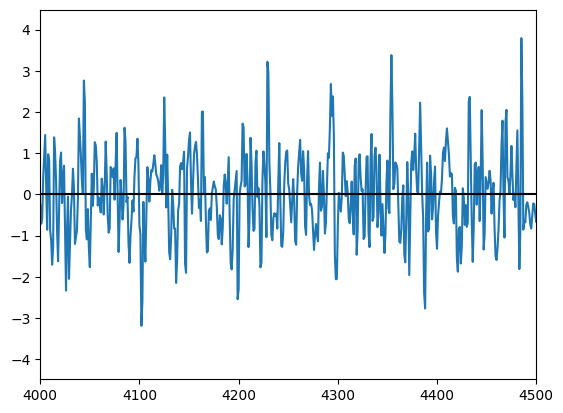

In [27]:
#plt.plot(_T.open)
plt.plot(_T.df.Z)
#plt.ylim()
plt.axhline(y=0, color = "black")
plt.xlim(4000,4500)
plt.show()

In [ ]:
elif b == False and (abs(data["VOL-Z"][i]) > 2.75 or abs(data["VOL-Z"][i]) <0.01):
    s = -1
    b = True    
elif b == False and (data["Close"][i] <= 0.995 * p or data["Close"][i] >= 1.05 * p):
    s = -1
    b = True

In [30]:
import backtrader as bt
import pandas as pd
from dataclasses import dataclass

# --- make a minimal Bar class compatible with your TF
@dataclass
class Bar:
    Open: float
    High: float
    Low: float
    Close: float

# ---- paste your TF, rolling_linreg_slope, wavelet_denoising here ----

class TFStrategy(bt.Strategy):
    params = dict(stake=1.0)  # if you want fixed shares

    def __init__(self):
        self.tf = TF()
        self.order = None

    def next(self):
        # prevent overlapping orders
        if self.order:
            return

        bar = Bar(
            Open=float(self.data.open[0]),
            High=float(self.data.high[0]),
            Low=float(self.data.low[0]),
            Close=float(self.data.close[0]),
        )

        self.tf._update(bar)
        dec = self.tf.decision()

        if dec == "buy" and not self.position:
            # sizing option 1: fixed stake
            self.order = self.buy(size=self.p.stake)

            # sizing option 2: "all in"
            # cash = self.broker.getcash()
            # size = cash / self.data.close[0]
            # self.order = self.buy(size=size)

        elif dec == "sell" and self.position:
            self.order = self.close()

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Rejected]:
            self.order = None


if __name__ == "__main__":
    # Example: feed a DataFrame (OHLCV)
    df = yf.download("AAPL", start="2000-01-01", end="2025-01-01")
    df.columns = df.columns.droplevel(1)
    data = bt.feeds.PandasData(dataname=df)  # expects Open/High/Low/Close/Volume columns

    cerebro = bt.Cerebro()
    cerebro.adddata(data)

    # realistic costs
    cerebro.broker.setcash(100000)
    cerebro.broker.setcommission(commission=0.0005)  # 5 bps

    # slippage (simple)
    cerebro.broker.set_slippage_perc(perc=0.0005)  # 5 bps

    cerebro.addstrategy(TFStrategy, stake=10)

    # analyzers (Sharpe, Drawdown, etc.)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")
    cerebro.addanalyzer(bt.analyzers.Returns, _name="rets")

    res = cerebro.run()
    strat = res[0]

    print("Sharpe:", strat.analyzers.sharpe.get_analysis())
    print("Drawdown:", strat.analyzers.dd.get_analysis())
    print("Returns:", strat.analyzers.rets.get_analysis())

    cerebro.plot()


[*********************100%***********************]  1 of 1 completed


Sharpe: OrderedDict({'sharperatio': -0.4497463194578437})
Drawdown: AutoOrderedDict({'len': 693, 'drawdown': 0.6816823548471758, 'moneydown': 687.1071523408027, 'max': AutoOrderedDict({'len': 1302, 'drawdown': 0.8548817332830312, 'moneydown': 861.6848436336004})})
Returns: OrderedDict({'rtot': 0.0010862932309353794, 'ravg': 1.7272908744401007e-07, 'rnorm': 4.3528677381276796e-05, 'rnorm100': 0.0043528677381276795})


<IPython.core.display.Javascript object>